# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [30]:
import pandas as pd
import numpy as np

import plotly.graph_objects as go
import plotly_express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose



In [3]:
data = pd.read_csv("https://practicum-content.s3.us-west-1.amazonaws.com/datasets/taxi.csv?etag=11687de0e23962e5a11c9d8ae13eb630", index_col=0, parse_dates=[0])

In [4]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


## Análisis

In [14]:
data_day = data.resample("1D").sum()
fig = px.line(data_day)
fig.show()

In [38]:
pd.Series(data_day.index)

0     2018-03-01
1     2018-03-02
2     2018-03-03
3     2018-03-04
4     2018-03-05
         ...    
179   2018-08-27
180   2018-08-28
181   2018-08-29
182   2018-08-30
183   2018-08-31
Name: datetime, Length: 184, dtype: datetime64[ns]

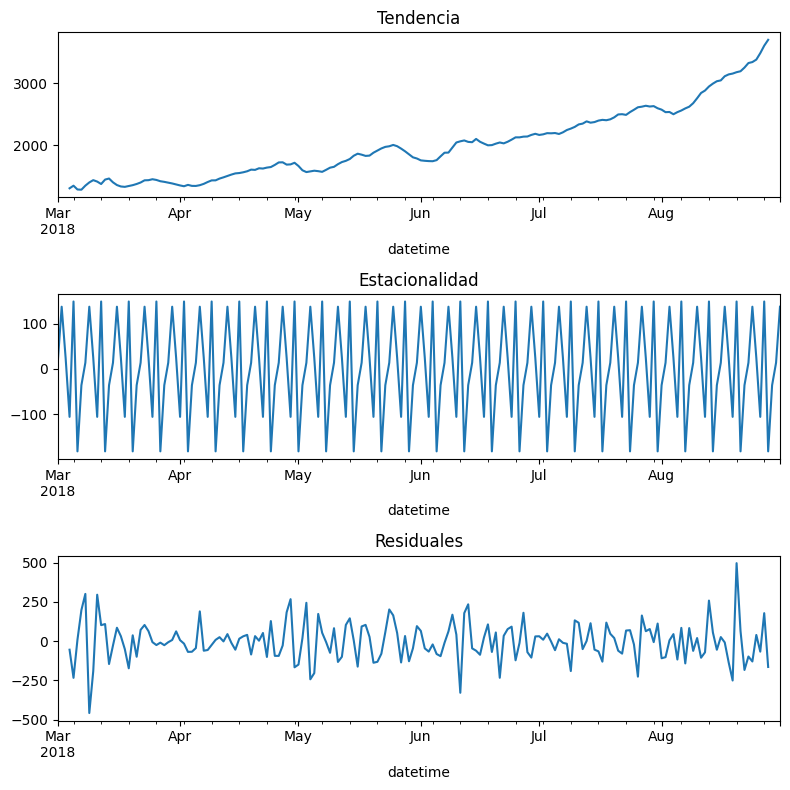

In [17]:
decomposed = seasonal_decompose(data_day)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')

# plt.subplot(x,y,z) dice que las imágenes forman una tabla
# de x filas y y columnas.
# z es el lugar de la imagen actual.

# plt.subplot(311) dice 3 filas, 1 columna, primera imagen. 

plt.tight_layout()    # esto ayuda a encajar gráficos secundarios en el área

In [41]:
fig = make_subplots(rows=3, cols=1, column_titles=["Tendencia", "Estacionalidad", "Residuales"])

for i, comp in enumerate(["trend", "seasonal", "resid"]):
    dataframe = pd.DataFrame({"date" : pd.Series(data_day.index), comp : getattr(decomposed, comp)})
    fig.add_trace(
        go.Scatter(x=dataframe['date'], y=dataframe[comp], name=comp.capitalize()),
        row=i, col=1
    )
fig.update_layout(height=600, width=600, title_text="Descomposición de Serie Temporal")
fig.show()

Exception: Row value is out of range. Note: the starting cell is (1, 1)

## Formación

## Prueba

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [ ]  Se ha realizado el paso 2: los datos han sido analizados
- [ ]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [ ]  Se han evaluado los modelos. Se expuso una conclusión
- [ ] La *RECM* para el conjunto de prueba no es más de 48